# Feature Normalization and Pairwise Transform

In this notebook, we cover the third step of Learning to Rank: Before training a model, LTR often requires a level of transformation to make the the problem suitable for classic machine learning approaches. In this notebook, we transform our the judgment list generated from [the previous step](2.ch10-judgments-and-logging.ipynb) first by normalizing the features using their mean & stand deviation. After that we examine a pair-wise transform used by the SVMRank model to make LTR a binary classification problem.

In [1]:
import requests
import sys
sys.path.append('..')
from ltr.client.solr_client import SolrClient

client = SolrClient(host='http://aips-solr:8983/solr')



## Recreate last section

Rebuild everything from last section we'll need to work with the full training set. 

Start by making sure the feature set is installed.

In [ ]:

requests.delete('http://aips-solr:8983/solr/tmdb/schema/feature-store/movies')

import requests

feature_set = [
    {
      "name" : "title_bm25",
      "store": "movies",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "title:(${keywords})"
      }
    },
    {
      "name" : "overview_bm25",
      "store": "movies",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "overview:(${keywords})"
      }
    },
    {
      "name" : "release_year",
      "store": "movies",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "{!func}release_year"
}}]

resp = requests.put('http://aips-solr:8983/solr/tmdb/schema/feature-store',
                    json=feature_set)
resp.text

## Log large training set

Log the full training set of ~100 movie queries, each with ~40 graded documents. Save judgment list with features logged as `logged_judgments`

In [3]:
from ltr.log import FeatureLogger
from ltr.judgments import judgments_open
from itertools import groupby
from ltr import download

ftr_logger=FeatureLogger(client, index='tmdb', feature_set='movies')

with judgments_open('data/ai_pow_search_judgments.txt') as judgment_list:
    for qid, query_judgments in groupby(judgment_list, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with title_bm25, overview_bm25, and release_year 
# logged out
logged_judgments

Recognizing 105 queries...
Searching tmdb [Status: 200]
Discarded 0 Keep 41
Searching tmdb [Status: 200]
Discarded 0 Keep 41
Searching tmdb [Status: 200]
Discarded 0 Keep 39
Searching tmdb [Status: 200]
Discarded 0 Keep 28
Searching tmdb [Status: 200]
Discarded 0 Keep 33
Searching tmdb [Status: 200]
Discarded 0 Keep 39
Searching tmdb [Status: 200]
Discarded 0 Keep 35
Searching tmdb [Status: 200]
Discarded 0 Keep 38
Searching tmdb [Status: 200]
Discarded 0 Keep 35
Searching tmdb [Status: 200]
Discarded 0 Keep 31
Searching tmdb [Status: 200]
Discarded 0 Keep 28
Searching tmdb [Status: 200]
Discarded 0 Keep 34
Searching tmdb [Status: 200]
Discarded 0 Keep 31
Searching tmdb [Status: 200]
Discarded 0 Keep 30
Searching tmdb [Status: 200]
Discarded 0 Keep 35
Searching tmdb [Status: 200]
Discarded 0 Keep 31
Searching tmdb [Status: 200]
Discarded 0 Keep 31
Searching tmdb [Status: 200]
Discarded 0 Keep 35
Searching tmdb [Status: 200]
Discarded 0 Keep 32
Searching tmdb [Status: 200]
Discarded 0 K

[Judgment(grade=1,qid=1,keywords=rambo,doc_id=7555,features=[5.9264307, 5.078817, 2008.0],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1370,features=[5.025649, 5.751174, 1988.0],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1369,features=[3.4517245, 4.8904457, 1985.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=13258,features=[0.0, 4.5890946, 2007.0],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1368,features=[0.0, 5.394124, 1982.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=31362,features=[0.0, 3.7886639, 1988.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=61410,features=[0.0, 2.1226306, 2010.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=319074,features=[0.0, 0.0, 2015.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=10296,features=[0.0, 0.0, 2004.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=35868,features=[0.0, 0.0, 2001.0],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=1

## Plot logged features

*Source for Figs 10.7*

This data set also has queries `star wars` and `social network` let's see what those look like by plotting the raw BM25 features we logged for documents labeled relevant / irrelevant.

Data points note:

- The green + in the upper right is "The Social Network"
- The red + with the largest `title_bm25` score is "Star Wars"
- The red + with ~6 `title_bm25` and ~5 `overview_bm25` is "Star Wars: The Clone Wars"

In [4]:
from ltr.plots import plot_judgments

plot_judgments(qids=[11,40], focus=[11,40], 
               xlabel="Title BM25",
               ylabel="Overview BM25",
               title_prepend="Logged features for queries:",
               judg_list=ftr_logger.logged)

## Feature Normalization Function (omitted from book)

As we describe in the book, SVMs are sensitive to the range of the underlying data. They work best with normalized features, which we do here.

This function computes the mean and standard deviation of all 3 of our features, then scales each feature value accordingly so that feature values at the mean are mapped to 0. And +1 corresponds to 1 std deviation above the mean. -1 1 standard deviation below, etc

We capture the mean and standard deviation of each feature for later work

In [5]:
from ltr.judgments import Judgment

def normalize_features(logged_judgments):
    all_features = []
    means = [0,0,0]
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0, 0.0, 0.0]
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    # Normalize!
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

normed_judgments

[Judgment(grade=1,qid=1,keywords=rambo,doc_id=7555,features=[3.101419298310874, 2.9435572663457967, 0.7345398019737361],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1370,features=[2.5643638127604715, 3.39208088257628, -0.2672174491148639],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1369,features=[1.6259735384385419, 2.817896379837532, -0.4174810367781539],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=13258,features=[-0.4319807665098383, 2.6168676330154805, 0.6844519394193062],weight=1,
 Judgment(grade=1,qid=1,keywords=rambo,doc_id=1368,features=[-0.4319807665098383, 3.1538958749462647, -0.5677446244414439],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=31362,features=[-0.4319807665098383, 2.082907144605458, -0.2672174491148639],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=61410,features=[-0.4319807665098383, 0.9715105495281311, 0.8347155270825962],weight=1,
 Judgment(grade=0,qid=1,keywords=rambo,doc_id=319074,features=[-0.43198076650

## Listing 10.8 - Normalize

Perform the normalization, and inspect the difference between of "The Social Network" between raw/logged and normalized feature values. 

In [6]:
means, std_devs, normed_judgments = normalize_features(logged_judgments)

logged_judgments[360], normed_judgments[360]

(Judgment(grade=1,qid=11,keywords=social network,doc_id=37799,features=[8.243603, 3.8143613, 2010.0],weight=1,
 Judgment(grade=1,qid=11,keywords=social network,doc_id=37799,features=[4.482941696779275, 2.100049660821875, 0.8347155270825962],weight=1)

## Examine normalized judgments
*Source for Figs 10.8-10.11*

Examine the normalized judgments now, in preperation for transforming them with SVMRank's pair-wise transform

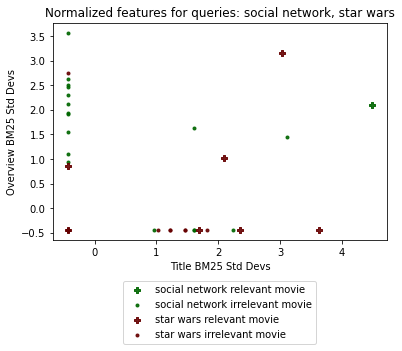

In [7]:
from ltr.plots import plot_judgments

plot_judgments(qids=[11,40], 
               xlabel="Title BM25 Std Devs",
               ylabel="Overview BM25 Std Devs",
               title_prepend="Normalized features for queries:",
               judg_list=normed_judgments)

# Listing 10.9 (Python Equivelant)

Pairwise transformation from per-query judgmens -> feature and predictor deltas

We put psuedocode in the book, but here we show the equivelant Python code. This code also transforms the data to a numpy array of predictors and features for later model training with an SVM.

In [7]:
import numpy as np
from ltr.judgments import judgments_from_file, judgments_to_nparray

def pairwise_transform(normed_judgments):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):

        # Annoying issue consuming python iterators, we ensure we have two
        # full copies of each query's judgments
        query_judgments_copy_1 = list(query_judgments) 
        query_judgments_copy_2 = list(query_judgments_copy_1)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if judgment1 more relevant
        # -1 if judgment2 more relevant
        for judgment1 in query_judgments_copy_1:
            for judgment2 in query_judgments_copy_2:
                
                j1_features=np.array(judgment1.features)
                j2_features=np.array(judgment2.features)
                
                if judgment1.grade > judgment2.grade:
                    predictor_deltas.append(+1)
                    feature_deltas.append(j1_features-j2_features)
                elif judgment1.grade < judgment2.grade:
                    predictor_deltas.append(-1)
                    feature_deltas.append(j1_features-j2_features)

    # For training purposes, we return these as numpy arrays
    return np.array(feature_deltas), np.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

## Pair-wise deltas, Star Wars and Social Network
*source for Fig 10.9*

The training set showing pair-wise differences in each feature for each relevant / irrelevant combo in each query

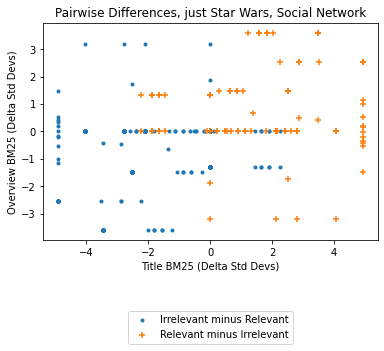

In [8]:
from ltr.plots import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_star_wars_social_network = []
for j in normed_judgments:
    if j.qid == 11 or j.qid == 40:
        just_star_wars_social_network.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_star_wars_social_network)
plot_pairwise_data(features, predictors,
                   xlabel="Title BM25 (Delta Std Devs)",
                   ylabel="Overview BM25 (Delta Std Devs)",
                   title="Pairwise Differences, just Star Wars, Social Network")

## Full dataset pairwise differences

*Source for Figure 10.14*

Note now with the full dataset's pairwise deltas computed, we can see relevant examples have a higher, positive `title_bm25` as we might expect.

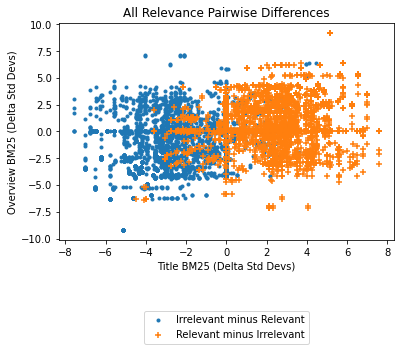

In [9]:
from ltr.plots import plot_pairwise_data

plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="Title BM25 (Delta Std Devs)",
                   ylabel="Overview BM25 (Delta Std Devs)",
                   title="All Relevance Pairwise Differences")

## Save intermediate data

For the next notebook, we save off out normalized, transformed pair-wise data. We also save the normalized full judgment list so we can do a test-training split and evaluate the model.

In [10]:
from ltr.judgments import judgments_to_file

with open('data/feature_data.npy', 'wb') as f:
    num_features=3
    feature_data = np.append(feature_deltas, [means, std_devs] )
    rows=feature_data.shape[0]//num_features    
    cols=num_features
    feature_data = feature_data.reshape((rows,cols))
    
    np.save(f, feature_data)
    
with open('data/predictor_deltas.npy', 'wb') as f:
    np.save(f, predictor_deltas )
    
with open('data/normed_judgments.txt', 'wt') as f:
    judgments_to_file(f, normed_judgments)

## Up next: finally training (and evaluating) a model

You're finally ready to train a model. Let's jump to it in the [next and final notebook for the chapter](4.ch10-train-and-evaluate-the-model.ipynb)